In [151]:
import time, datetime
import requests 
import pickle as pkl 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import json


import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


In [41]:
def query_prom(query, startTime, endTime, PROMETHEUS = 'http://20.71.55.156:9090/', debug=False):
    response = requests.get(PROMETHEUS + '/api/v1/query_range',
      params={'query': query,
              'start': startTime,
              'end': endTime,
              'step': '15s'})
    if debug:
        print(response.json())
    results = response.json()['data']['result']
    return results

In [42]:
from prometheus_api_client import PrometheusConnect
prom = PrometheusConnect(url ="http://20.71.55.156:9090", disable_ssl=True)

# Get the list of all the metrics that the Prometheus host scrapes
metrics = prom.all_metrics()
# import pprint
# pprint.pprint(metrics)

# We are interested resource related metrics (VM metrics)
node_metrics = [i for i in metrics if i.startswith('node_')]

print(f"By selecting VM metrics onlye, number of metrics reduce number of metrics from %i to %i" \
      %(len(metrics), len(node_metrics)))


By selecting VM metrics onlye, number of metrics reduce number of metrics from 620 to 236


In [43]:
startTime = 1619692800
endTime = 1619696520

startTime = 1620598279
endTime = 1620648679

startTime = 1621335960
endTime = 1621343220


In [44]:
caliper_txn_failure = list(map(float,np.array(query_prom('caliper_txn_failure', startTime, endTime)[0]['values'])[:,1]))


In [45]:
def caliper_df(label, startTime=startTime, endTime=endTime):
    label_data = query_prom(label, startTime, endTime, debug=False)[0]
    time = list(map(int, np.array(label_data['values'])[:,0]))
    value_t = list(map(float, np.array(label_data['values'])[:,1]))
    # transfer time from timestamp to datetime
    time_ax = []
    for each in time:
        time_ax.append(datetime.datetime.fromtimestamp(each))
    label = [0]
    for i in range(1,len(value_t)):
        if value_t[i]-value_t[i-1] != 0:
            label.append(1)
        else:
            label.append(0)
    return pd.DataFrame({'time': time_ax,'label': label})


# Caliper data for label
txn_failure = 'caliper_txn_failure'
label_data=caliper_df(txn_failure)

# query

In [46]:
# OLD

In [47]:
# def query_data(metric):
#     query = 'irate('+metric+'{device="sdb",instance="nodeexporter1",job="nodeexporter"}[5m])'
#     try:
#         result = query_prom(query, startTime, endTime)[0]
#         value = list(map(float, np.array(result['values'])[:,1]))
#         label_data[metric] = value
#         return value
#     except:
#         pass
    
# for metric in tqdm(node_metrics):
#     query_data(metric)

In [48]:
# New

In [49]:
queries = []
metric_names= []

with open('Node Exporter Full-1622052567560.json') as json_file:
    data = json.load(json_file)
    z = 0
    for j,i in enumerate(data['panels']):
        try:
            queries.append(i['targets'][0]['expr'])
            if len(i['description']) > 0:
                metric_names.append(i['description'])
            else:
                metric_names.append("unknown_metric_"+str(z))
                z+=1
        except:
            pass

        
        query = 'irate(node_disk_io_time_seconds_total{device="sdb",instance="nodeexporter1",job="nodeexporter"}[5m])'
query = ('(((count(count(node_cpu_seconds_total{instance="$node",job="$job"}) by '
 '(cpu))) - avg(sum by '
 '(mode)(rate(node_cpu_seconds_total{mode=\'idle\',instance="$node",job="$job"}[$__rate_interval])))) '
 '* 100) / count(count(node_cpu_seconds_total{instance="$node",job="$job"}) by '
 '(cpu))')
def set_query(query):
    query = query.replace('$job', 'nodeexporter')
    query = query.replace('$node', 'nodeexporter2')
    query = query.replace('$__rate_interval', '5m')
    return query

for i in queries:
    query = set_query(i)
    try:
        result = query_prom(query, startTime, endTime)[0]
    except:
        pass

In [122]:
def query_data(query, label):
    try:
        result = query_prom(query, startTime, endTime)[0]
        value = list(map(float, np.array(result['values'])[:,1]))
        label_data[label] = value
        return value
    except:
        pass

# todo get name from json
for query, metric_name in tqdm(zip(queries, metric_names)):
    query = set_query(query)
    query_data(query, metric_name)

In [123]:
# TODO Handle nan instead of fill 0
label_data = label_data.fillna(0)


<p style="color:red;">Looks like not all metrics hold data since query_prom(query, startTime, endTime)[0] is empty</p>

In [124]:
caliper_txn_failure = list(map(float,np.array(query_prom('caliper_txn_failure', startTime, endTime)[0]['values'])[:,1]))
label_data["caliper_txn_falure"] = caliper_txn_failure
label_data.head()

,time,label,Busy state of all CPU cores together,Busy state of all CPU cores together (5 min average),Busy state of all CPU cores together (15 min average),Non available RAM memory,Used Swap,Total number of CPU cores,System uptime,Total RAM,Total SWAP,Basic CPU info,Basic memory usage,Basic network info per interface,Disk space used of all filesystems mounted,unknown_metric_0,unknown_metric_1,unknown_metric_2,unknown_metric_3,caliper_txn_falure
0,2021-05-18 13:06:00,0,6.950000,4.25,21.25,23.388541,0.0,4.0,1.089743e+07,1.679186e+10,0.0,9.196610,1.679186e+10,1564.311864,37.241920,9.196610,9.249055e+08,1564.311864,1.155866e+10,12506.0
1,2021-05-18 13:06:15,0,7.016949,4.00,21.00,23.803510,0.0,4.0,1.089745e+07,1.679186e+10,0.0,9.213559,1.679186e+10,1568.650847,38.898826,9.213559,9.919160e+08,1568.650847,1.207291e+10,12506.0
2,2021-05-18 13:06:30,0,7.424576,3.75,20.50,17.132260,0.0,4.0,1.089746e+07,1.679186e+10,0.0,9.813559,1.679186e+10,1582.318644,35.703579,9.813559,1.085415e+09,1582.318644,1.108121e+10,12506.0
3,2021-05-18 13:06:45,1,8.510169,4.50,20.50,18.097213,0.0,4.0,1.089748e+07,1.679186e+10,0.0,11.227119,1.679186e+10,1580.040678,35.812509,11.227119,1.210036e+09,1580.040678,1.111502e+10,0.0
4,2021-05-18 13:07:00,0,10.101695,7.50,21.25,18.636683,0.0,4.0,1.089749e+07,1.679186e+10,0.0,13.088136,1.679186e+10,1577.762712,35.951873,13.088136,1.252499e+09,1577.762712,1.115827e+10,0.0


# Correlation
<p style="color:red;">Correlate with caliper txn falure or boolean labels?</p>

In [125]:
labels_to_correlate = label_data.drop(['label', 'caliper_txn_falure', 'time'], axis=1)

In [126]:
from scipy import stats
import pprint

correlation_txn_falure = {}
for label in labels_to_correlate.columns:
    r,p = stats.pearsonr(labels_to_correlate[label], label_data.caliper_txn_falure)
    correlation_txn_falure[label] = (p,r)


/home/ole/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<AxesSubplot:>

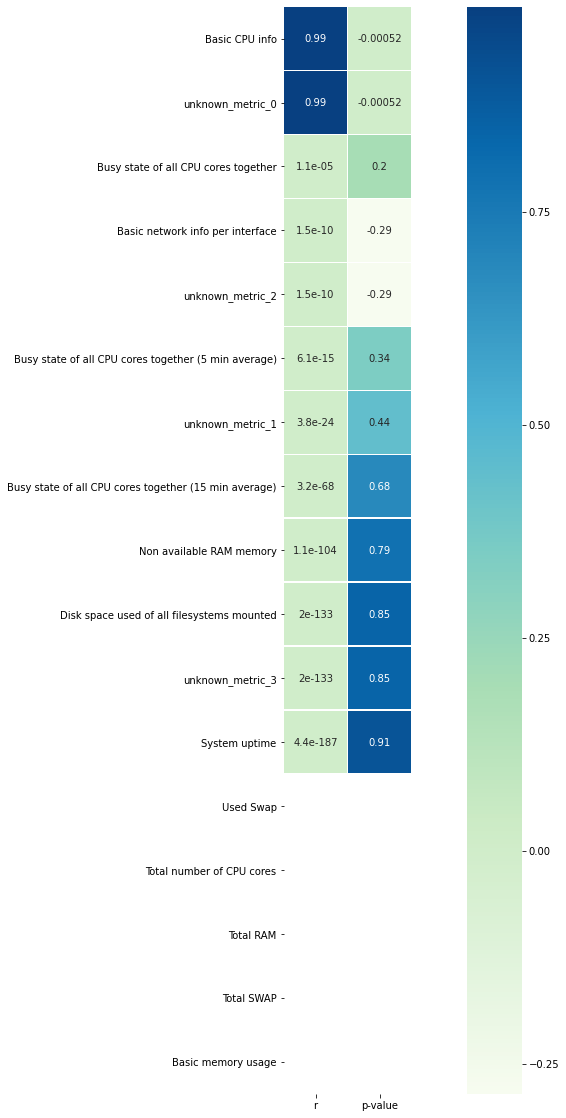

In [127]:
import seaborn as sns

txn_falure_correlation = pd.DataFrame.from_dict(correlation_txn_falure, orient='index').rename(columns={0:'r', 1:'p-value'}).sort_values('r', ascending=False)

plt.figure(figsize=(20,20))
sns.heatmap(txn_falure_correlation, cmap='GnBu', square=True, annot=True, linewidths=.5)

                                                   r   p-value
Basic network info per interface            0.389223 -0.039183
unknown_metric_2                            0.389223 -0.039183
System uptime                               0.037369  0.094558
Disk space used of all filesystems mounted  0.000004  0.207185
unknown_metric_3                            0.000004  0.207185


<AxesSubplot:>

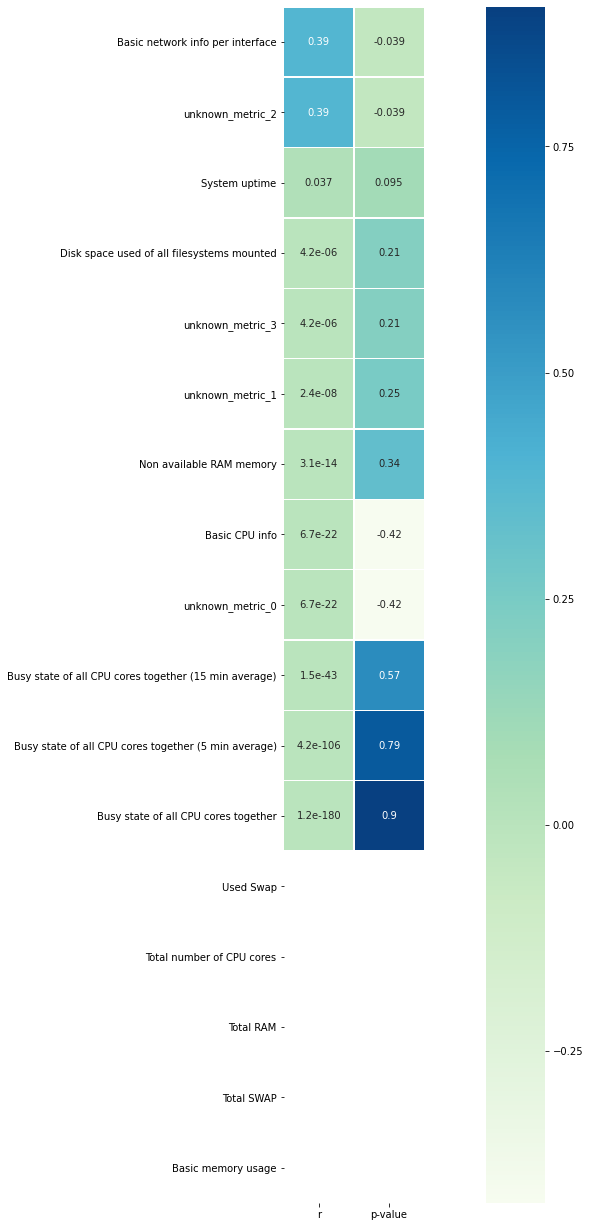

In [128]:
from scipy import stats
import pprint

correlation_txn_falure_bool = {}
for label in labels_to_correlate.columns:
    r,p = stats.pointbiserialr(labels_to_correlate[label], label_data.label)
    correlation_txn_falure_bool[label] = (p,r)
pointbiserialr = pd.DataFrame.from_dict(correlation_txn_falure_bool, orient='index').rename(columns={0:'r', 1:'p-value'}).sort_values('r', ascending=False)

print(pointbiserialr.head())
plt.figure(figsize=(22,22))
sns.heatmap(pointbiserialr, cmap='GnBu', square=True, annot=True, linewidths=.5)

<p style="color:red;">2 methods to calculate correlation, dont know which method is best for the data</p>

<AxesSubplot:>

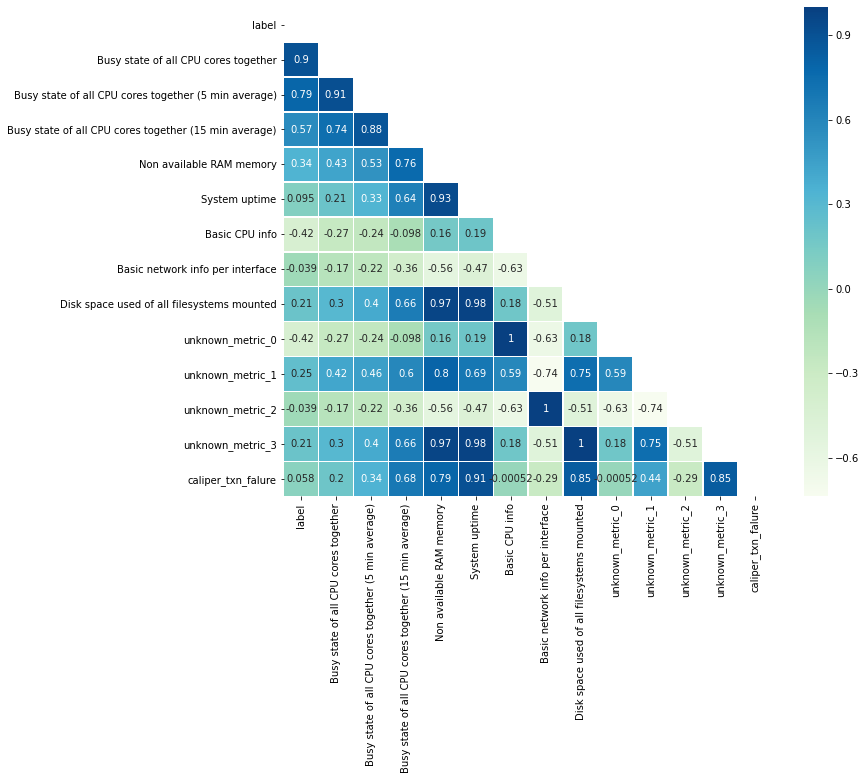

In [129]:
correlations = label_data.corr().dropna(axis=1, how='all').T.dropna(axis=1, how='all').T
# heatmap

matrix = np.triu(correlations)

plt.figure(figsize=(11,9))
sns.heatmap(correlations, cmap='GnBu', square=True, annot=True, linewidths=.5, mask=matrix)
#plt.savefig('xx.png')

In [130]:
label_data.head()

,time,label,Busy state of all CPU cores together,Busy state of all CPU cores together (5 min average),Busy state of all CPU cores together (15 min average),Non available RAM memory,Used Swap,Total number of CPU cores,System uptime,Total RAM,Total SWAP,Basic CPU info,Basic memory usage,Basic network info per interface,Disk space used of all filesystems mounted,unknown_metric_0,unknown_metric_1,unknown_metric_2,unknown_metric_3,caliper_txn_falure
0,2021-05-18 13:06:00,0,6.950000,4.25,21.25,23.388541,0.0,4.0,1.089743e+07,1.679186e+10,0.0,9.196610,1.679186e+10,1564.311864,37.241920,9.196610,9.249055e+08,1564.311864,1.155866e+10,12506.0
1,2021-05-18 13:06:15,0,7.016949,4.00,21.00,23.803510,0.0,4.0,1.089745e+07,1.679186e+10,0.0,9.213559,1.679186e+10,1568.650847,38.898826,9.213559,9.919160e+08,1568.650847,1.207291e+10,12506.0
2,2021-05-18 13:06:30,0,7.424576,3.75,20.50,17.132260,0.0,4.0,1.089746e+07,1.679186e+10,0.0,9.813559,1.679186e+10,1582.318644,35.703579,9.813559,1.085415e+09,1582.318644,1.108121e+10,12506.0
3,2021-05-18 13:06:45,1,8.510169,4.50,20.50,18.097213,0.0,4.0,1.089748e+07,1.679186e+10,0.0,11.227119,1.679186e+10,1580.040678,35.812509,11.227119,1.210036e+09,1580.040678,1.111502e+10,0.0
4,2021-05-18 13:07:00,0,10.101695,7.50,21.25,18.636683,0.0,4.0,1.089749e+07,1.679186e+10,0.0,13.088136,1.679186e+10,1577.762712,35.951873,13.088136,1.252499e+09,1577.762712,1.115827e+10,0.0


# Correlation analysis
<p style="color:red;">Use correlation with caliper_txn_falure or other metrics or both? Now use pearson correlation</p>

In [131]:
txn_falure_correlation

,r,p-value
Basic CPU info,9.908134e-01,-0.000524
unknown_metric_0,9.908134e-01,-0.000524
Busy state of all CPU cores together,1.147195e-05,0.197760
Basic network info per interface,1.487109e-10,-0.285570
unknown_metric_2,1.487109e-10,-0.285570
Busy state of all CPU cores together (5 min average),6.141157e-15,0.344231
unknown_metric_1,3.786564e-24,0.437969
Busy state of all CPU cores together (15 min average),3.188254e-68,0.684208
Non available RAM memory,1.135840e-104,0.789969
Disk space used of all filesystems mounted,2.010102e-133,0.845052


In [142]:
# drop unkonwn metrics looks like those are duplicates
df_index = list(txn_falure_correlation.index)
remove_from_index = [x for x in df_index if 'unknown_metric' in x]

txn_falure_correlation = txn_falure_correlation.drop(remove_from_index)
# drop Nan
txn_falure_correlation = txn_falure_correlation.dropna(axis='rows')

<p style="color:red;">How to justify threshold? </p>

In [167]:
selected_features = txn_falure_correlation[txn_falure_correlation.r >1.147195e-06]
selected_features_names = selected_features.index
selected_features

,r,p-value
Basic CPU info,0.990813,-0.000524
Busy state of all CPU cores together,0.000011,0.197760


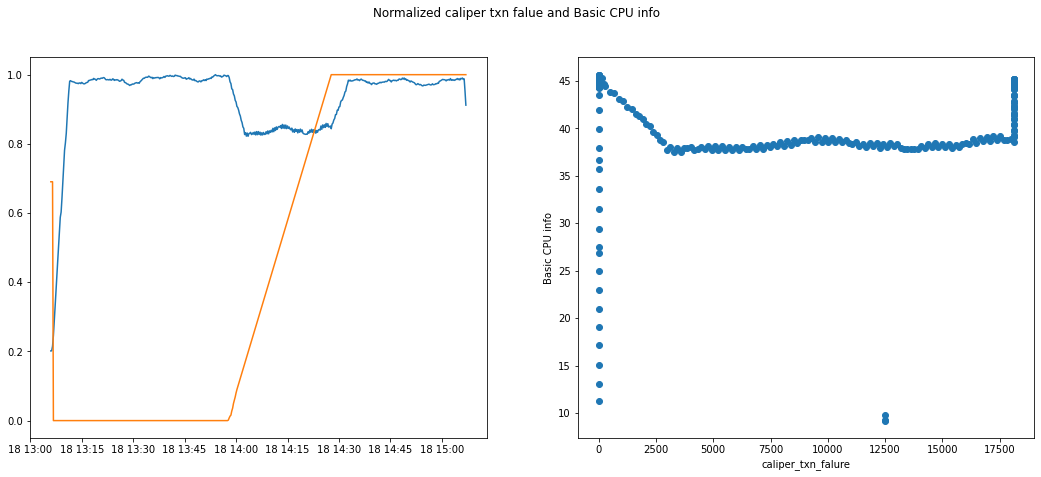

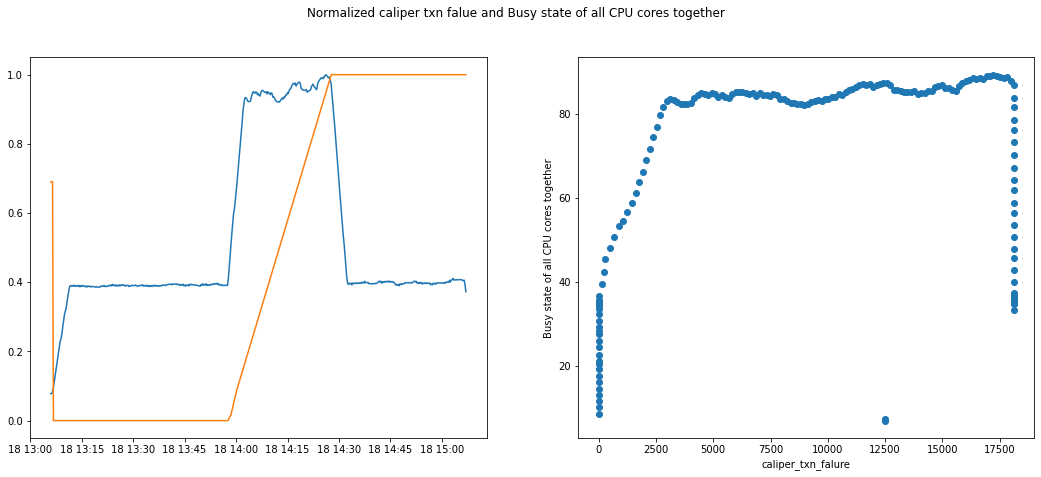

In [178]:
from sklearn.preprocessing import MinMaxScaler
normalized_label_data = label_data.copy()

for i in normalized_label_data.drop(['time'], axis=1).columns:  
    normalized_label_data[i]/=normalized_label_data[i].max()

for feature in selected_features_names:
    fig, ax =plt.subplots(figsize=(18,7))
    
    plt.subplot(1,2,1)
    plt.plot(normalized_label_data['time'], normalized_label_data[feature], label=feature)
    plt.plot(normalized_label_data['time'],normalized_label_data['caliper_txn_falure'],label='caliper_txn_falue')
    
    plt.subplot(1,2,2)
    plt.suptitle("Normalized caliper txn falue and "+feature)
    plt.scatter(label_data['caliper_txn_falure'], label_data[feature])
    plt.xlabel('caliper_txn_falure')
    plt.ylabel(feature)
#     plt.plot(normalized_label_data['time'],normalized_label_data['caliper_txn_falure'],label='caliper_txn_falue')
    plt.show()